In [1]:
import os
from collections import defaultdict
from statistics import median

from scipy import mean
from scipy.stats import gmean
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
import champsim_parser

In [2]:
total_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))

dirs = {
    'LRU': 'data/mem-traces/lru-0/',
    's3fifo': 'data/mem-traces/s3fifo-0/'
}

configs = []
for key, dir in dirs.items():
    for folder in os.listdir(dir):
        file_path = dir+folder
        result_dict = champsim_parser.process_directory(file_path)
        total_dict[key][folder] = result_dict
        configs.append(folder)

In [3]:
files = set()
median_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for part, part_dict in total_dict.items():
    for config, result_dict in part_dict.items():
        for file, counter_dict in result_dict.items():
            files.add(file)
            for counter, lis in counter_dict.items():
                median_dict[part][config][file][counter] = median(sorted(lis))

In [4]:
eps=1e-6
data_dict = defaultdict(lambda: defaultdict(dict))
ipc_dict= defaultdict(int)
count_ipc_dict = defaultdict(dict)
default="default"
for p in dirs.keys():
    for f in files:
        for c in configs:
            try:
                data_dict[p][f][("Speedup", c)] = median_dict[p][default][f]["ipc"] / median_dict[p][c][f]["ipc"]
                data_dict[p][f][("bMPKI", c)] = median_dict[p][c][f]["bMPKI"]
                data_dict[p][f][("IPC", c)] = median_dict[p][c][f]["ipc"]
                data_dict[p][f][("branch_prediction_accuracy", c)] = median_dict[p][c][f]["branch_prediction_accuracy"]
                data_dict[p][f][("LLC_MPKI", c)] = median_dict[p][c][f]["llc_miss"]/median_dict[p][c][f]["instructions"]*1000
            except:
                data_dict[p][f][("Speedup", c)] = eps
                data_dict[p][f][("bMPKI", c)] = eps
                data_dict[p][f][("IPC", c)] = eps
                data_dict[p][f][("branch_prediction_accuracy", c)] = eps
                data_dict[p][f][("LLC_MPKI", c)] = eps

            if p == "Mockingjay":
                #print(p, median_dict[p][c][f]["ipc"])
                ipc_dict[c] += median_dict[p][c][f]["ipc"]
                count_ipc_dict[f][c] = median_dict[p][c][f]["ipc"]

dfs = {}
for p, dic in data_dict.items():
    df = pd.DataFrame(dic).T
    df = df.rename_axis("Executable")
    df = df.sort_index()
    df = df.sort_index(axis=1)
    dfs[p] = df

ipc_dict = {k: v / len(files) for k, v in ipc_dict.items()}
ipc_dict = dict(sorted(ipc_dict.items(), key=lambda item: item[1]))

# count how many times an executable had the fastest time
sorted_defaultdict = defaultdict(dict)
for key, sub_dict in count_ipc_dict.items():
    sorted_defaultdict[key] = dict(sorted(sub_dict.items(), key=lambda item: item[1]))
count_ipc_dict = sorted_defaultdict
cnt_temp = defaultdict(int)
for file in count_ipc_dict.keys():
    cnt_temp[list(count_ipc_dict[file].keys())[0]] += 1
count_ipc_dict = cnt_temp
for c in configs:
    if c not in count_ipc_dict:
        count_ipc_dict[c] = 0
count_ipc_dict = dict(sorted(count_ipc_dict.items(), key=lambda item: item[1]))

In [5]:
print("Geometric Mean IPC Speedup over LRU")
for i, (p, df) in enumerate(dfs.items()):
    if p != "LRU":
        speedups = df[("IPC",)]/dfs["LRU"][("IPC",)]
        print(p, gmean(speedups))

Geometric Mean IPC Speedup over LRU
s3fifo [0.90549816]


In [6]:
bar_height = .2
figsize=(15,15)

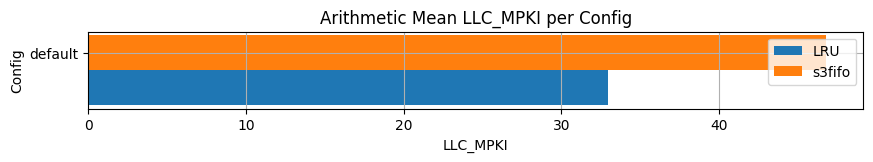

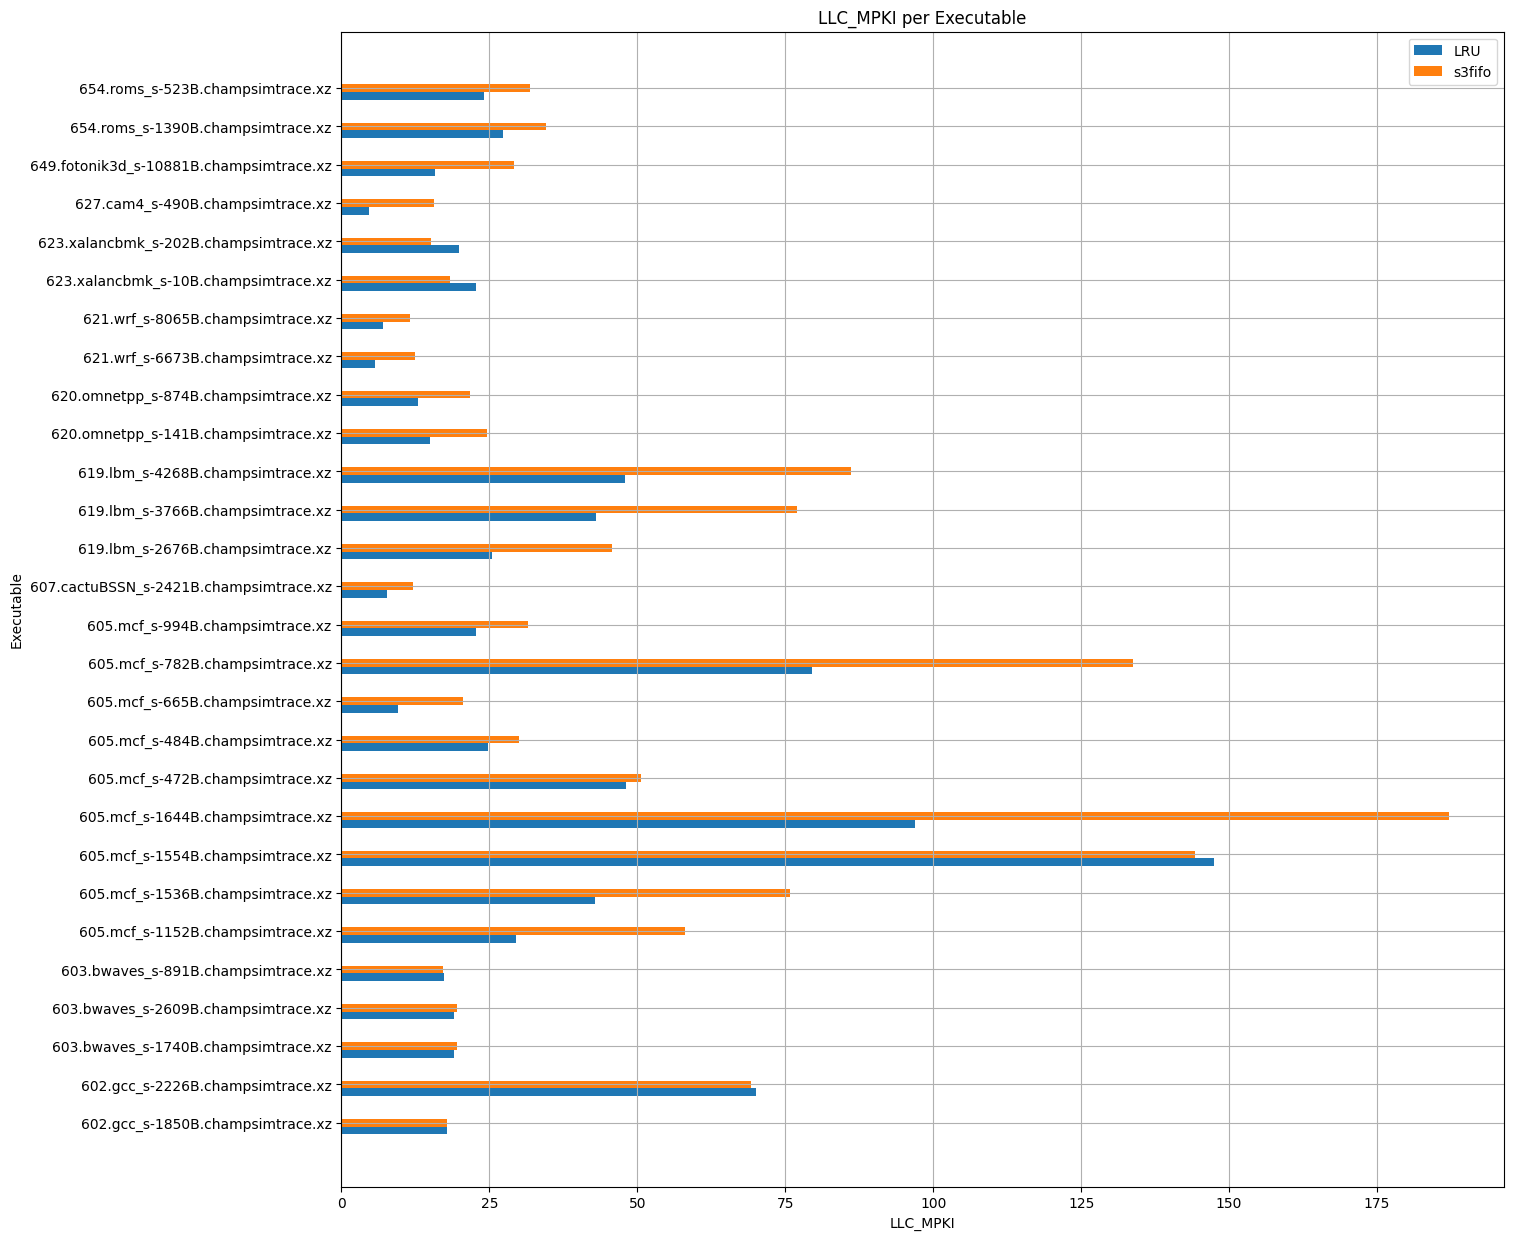

In [7]:
metric="LLC_MPKI"
plt.figure(figsize=(10,1))
for i, (p, df) in enumerate(dfs.items()):
    mean_df = df[(metric,)].mean(axis=0)
    y = np.arange(len(mean_df.index))
    plt.barh(y+i*bar_height, mean_df.values, label=p, tick_label=mean_df.index, height=bar_height)
plt.title(f"Arithmetic Mean {metric} per Config")
plt.ylabel("Config")
plt.xlabel(metric)
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=figsize)
for i, (p, df) in enumerate(dfs.items()):
    mean_df = df[(metric,)].mean(axis=1)
    y = np.arange(len(mean_df.index))
    plt.barh(y+i*bar_height, mean_df.values, label=p, tick_label=mean_df.index, height=bar_height)
plt.title(f"{metric} per Executable")
plt.ylabel("Executable")
plt.xlabel(metric)
plt.grid()
plt.legend()
plt.show()

Arithmetic/Geometric Mean IPC per Config
LRU [0.65246786] [0.51832969]
s3fifo [0.58965464] [0.46934658]


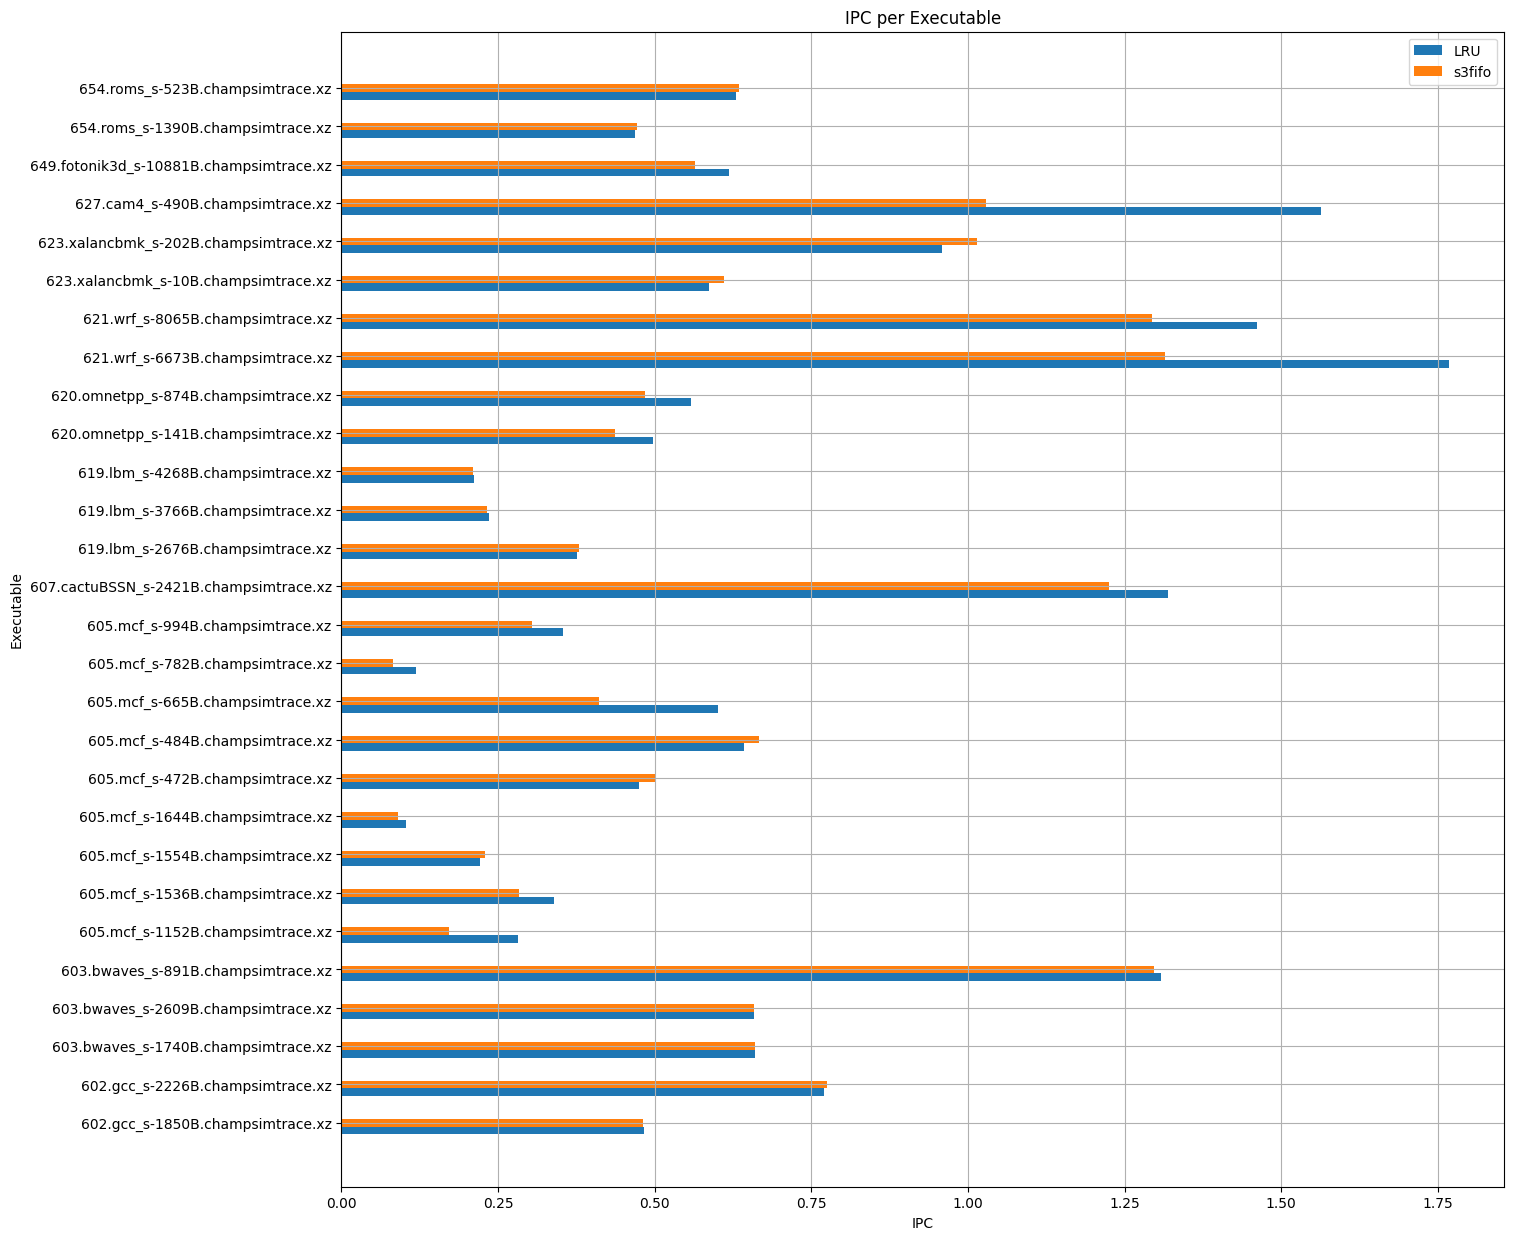

In [8]:
metric="IPC"
print(f"Arithmetic/Geometric Mean {metric} per Config")
for i, (p, df) in enumerate(dfs.items()):
    mean_df = df[(metric,)].mean(axis=0)
    y = np.arange(len(mean_df.index))
    print(p, mean_df.values, gmean(df[(metric,)]))

plt.figure(figsize=figsize)
for i, (p, df) in enumerate(dfs.items()):
    mean_df = df[(metric,)].mean(axis=1)
    y = np.arange(len(mean_df.index))
    plt.barh(y+i*bar_height, mean_df.values, label=p, tick_label=mean_df.index, height=bar_height)
plt.title(f"{metric} per Executable")
plt.ylabel("Executable")
plt.xlabel(metric)
plt.grid()
plt.legend()
plt.show()